In [1]:
import os
import openai
from tqdm import tqdm
import pandas as pd
import numpy as np

from IPython import display

cwd = os.getcwd()

## Main GPT Functions

In [112]:
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
openai.api_key = OPENAI_API_KEY

def run_gpt(messages, this_model="gpt-3.5-turbo"):
    response = openai.ChatCompletion.create(
        model=this_model,
        messages=messages
    )
    return response


def gpt_oneshot(input_prompt, directive="You are a helpful assistant.", verbose=False):
    message_hist = [{"role": "system", "content": directive},  # add directed
                    {"role": "user", "content": input_prompt}]  # init
    response = run_gpt(message_hist)["choices"][0]["message"]["content"]
    if verbose:
        print("chat_gpt: ", response, '\n')
#     message_hist.append({"role": "system", "content": response})
    return response

In [164]:
# https://platform.openai.com/docs/guides/vision
def gpt_image_oneshot(image_link, new_prompt="This image contains some information about Verilog. Please respond with a question\
                                            for which the answer is the code snippet on this page.",
                        role="You are a helpful assistant that gives information on images of code.", 
                        retry=2, verbose=False):
    # "This image contains a block of Verilog code and text relating to it. "+...
    new_content = [{"type": "text", "text": new_prompt},
                    {"type": "image_url", "image_url": {"url": image_link}}]  # "I am the owner/maker of this image", "I am an ML researcher"
    message_hist = [{"role": "system", "content": role},
                    {"role": "user", "content": new_content}]  # init
    if verbose:
        print("Asked:", new_content[0]["text"])
#         print("With Image:", new_content[1]["image_url"]["url"])
    attempts = 0
    response = ""
    while response == "" and attempts < retry:
        try:
            response = run_gpt(message_hist, "gpt-4-vision-preview").choices[0].message.content
        except Exception as e:
            attempts += 1
            if verbose: print("Encountered error:", e)
    if verbose: print("\nResponded With:", response)
    return response
# TODO account for timout issue
# TODO account for copyright

# test_image1 = cwd+"/testpage.jpg"
# base64_image = encode_image(image_path)
# my_link3 = f"data:image/jpeg;base64,{base64_image}"
# rep = gpt_image_oneshot(my_link3, "Please respond with a question for which the answer is the code snippet on this page.", True)

# print()
# for code_snip in get_code(rep):
#     print(code_snip)
#     print()

# display.Image(file_dir)

### Cleaning Functions

In [6]:
def get_failed_request(df, identifier="I'm sorry", setna=True, verbose=True):
    inds = set()
    messages = set()
    failed_count = 0
    for i, row in df.iterrows():
        for col in df.columns:
            if identifier in str(row[col]):
                inds.add(i)
                messages.add(row[col])
                failed_count += 1
                if setna:
                    df.loc[i, col] = np.nan
    if verbose:
        copy_count = sum([1 for mes in messages if "copyright" in mes])
        print("found", len(inds), "rows with bad requests and a total of", failed_count, "cells of bad calls")
        print(len(messages), "of which where unique and", copy_count, "of which were identified as copyright related")
        if len(messages) > 0:
            print("\nan example of this is:\n", list(messages)[0])
    return df, failed_count, messages, inds

### Helpers

In [7]:
# helpers
import base64

# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')


def get_code(text):
    if text is None or len(text) == 0:
        return []
    this_code = []
    for i, code_chunk in enumerate(text.split('```')):  # pieces of code are denoted by ``` so we split
        if i%2 == 1:  # every other chunk is a piece of code in this case
            this_code.append(code_chunk[7:])  # Note: code declarations also have 'python\n' denoting the language, since we dont need this, we omit the first 7 chars
    return this_code


## Code Extraction Functions

In [165]:
prompt_precursor = "This image contains some information about Verilog. "
bad_message = "NO CODE"
ask_code = prompt_precursor+"If there is some code on this page then please write it. Otherwise say \""+bad_message+"\""
# supervised addition
ask_caption = "This image contains some Verilog code on it. Please give a short caption to describe this code."
# additional queries
ask_question = "This image contains some Verilog code on it. ONLY respond with a question for which the answer is the code snippet on this page. Make sure to phrase the question as if you are a Verilog programmer asking for some help."
question_examples = """Examples of types of questions:
How can I add ___?
Give me a module/implementation of a ___?
How does ___ work?
I want to write Verilog for ___?
Explain ___ concept using an example?
What is the difference between ___ and ___?
"""
ask_question += '\n' + question_examples


indicators = ["```"]
def has_code(message):
    message = message.strip()
    if bad_message in message:
        return False  # instant signal
    for ind in indicators:
        if ind in message:
            return True
    return False

def extract_code(image_path, verbose=False):
    """ takes in the link of a local image and gets information about code on it """
    base64_image = encode_image(image_path)
    image_link = f"data:image/jpeg;base64,{base64_image}"
    
    raw_code = gpt_image_oneshot(image_link, ask_code)
    if raw_code == "":
        print("*couldnt get code after 2 attempts")
        return [image_path, False, np.nan, np.nan, np.nan, np.nan]
    else:  # only run subsequent queries if we identify response
        processed_code = np.nan
        caption = np.nan
        question = np.nan
        is_code = has_code(raw_code)
        if is_code:  # check if there is code
            processed_code = '\n'.join(get_code(raw_code))  # NOTE: aggregation not necessary
            # * process caption
            caption = gpt_image_oneshot(image_link, ask_caption)
            # * process question
            question = gpt_image_oneshot(image_link, ask_question)
        has_finished = is_code and np.isnan(caption) and np.isnan(question)  # signifier that we have consistent output on both fronts
        return [image_path, has_finished, raw_code, processed_code, caption, question]

In [166]:
# Prompts Used Above:
for prompt in [ask_code, ask_caption, ask_question]:
    print(prompt)
    print()

This image contains some information about Verilog. If there is some code on this page then please write it. Otherwise say "NO CODE"

This image contains some Verilog code on it. Please give a short caption to describe this code.

This image contains some Verilog code on it. Please respond with a question for which the answer is the code snippet on this page.



### Pipeline

In [75]:
# find file directories
data_dir = "Data/example-code/supervised-textbook/paginated/"  # from my 10 books
my_ims = [data_dir+file for file in os.listdir(data_dir) if 'jpg' in file]
print("Found", len(my_ims), "files\n")

# for partial execution on google and partial on my computer
new_data_dir = "Data/example-code/supervised-textbook/extra-paginated/"  # from Andre's 60 books
new_ims = [file for file in os.listdir(new_data_dir) if 'jpg' in file]
print("Found additional", len(new_ims), "books")
partial_ims = [new_data_dir+file for file in new_ims if 'book' not in file.lower()]  # 21728 - 13573 = 8155
print("For partial execution, allocating", len(partial_ims), "books")
# partial_ims = partial_ims[9500:]
# print("segmented into", len(partial_ims))

ims = partial_ims + my_ims
print("\nTotal books:", len(ims))

# NOTE: should be 26550 books once aggregated - 49% of which are being processed on local

Found 4822 files

Found additional 21728 books
For partial execution, allocating 8155 books

Total books: 12977


In [86]:
# process them
results = []
# checkpointing
checkpoint_dir = "Data/example-code/supervised-textbook/checkpoints/textbook2-gpt"
delim = 100 if len(ims) > 100 else len(ims)
print("Processing textbooks with checkpoints every", delim)
for i, im in tqdm(enumerate(ims)):
    results.append(extract_code(im, 2))
    if i > 0 and ((i%delim) == 0 or i >= (len(ims)-1)):  # save partial execution
        df = pd.DataFrame(results, columns=["image_directory", "isComplete", "raw_code", "code", "caption", "quesiton"])
        save_dir = checkpoint_dir+str(i-delim)+"-"+str(i)+".csv"
        df.to_csv(save_dir, index=False)
        print("SAVED TO ", save_dir)
        print()
        results = []

Processing textbooks with checkpoints every 100


101it [16:46, 10.60s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt0-100.csv



201it [41:41, 12.32s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt100-200.csv



301it [1:02:42,  7.44s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt200-300.csv



401it [1:16:19, 10.75s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt300-400.csv



501it [1:32:46,  8.58s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt400-500.csv



601it [1:45:12, 13.13s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt500-600.csv



701it [1:58:17,  3.31s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt600-700.csv



801it [2:15:39, 11.83s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt700-800.csv



901it [2:33:25, 12.20s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt800-900.csv



1001it [2:48:34, 10.93s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt900-1000.csv



1101it [3:07:38, 12.44s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt1000-1100.csv



1201it [3:27:43,  8.51s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt1100-1200.csv



1301it [3:41:06,  4.37s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt1200-1300.csv



1401it [3:54:16,  4.16s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt1300-1400.csv



1501it [4:10:14,  4.80s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt1400-1500.csv



1601it [4:18:44,  8.11s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt1500-1600.csv



1701it [4:26:48, 11.49s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt1600-1700.csv



1801it [4:42:08,  8.64s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt1700-1800.csv



1901it [4:56:33,  3.51s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt1800-1900.csv



2001it [5:14:37, 10.42s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt1900-2000.csv



2101it [5:36:44, 11.52s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt2000-2100.csv



2201it [5:55:34, 10.03s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt2100-2200.csv



2301it [6:19:30, 20.47s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt2200-2300.csv



2401it [6:39:26, 12.80s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt2300-2400.csv



2501it [7:00:57, 13.59s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt2400-2500.csv



2601it [7:25:28,  7.53s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt2500-2600.csv



2701it [7:50:29, 17.85s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt2600-2700.csv



2801it [8:13:36, 13.48s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt2700-2800.csv



2901it [8:30:28,  3.37s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt2800-2900.csv



3001it [8:39:17,  3.54s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt2900-3000.csv



3101it [8:47:08, 12.40s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt3000-3100.csv



3201it [9:04:19, 10.73s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt3100-3200.csv



3301it [9:30:10, 17.87s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt3200-3300.csv



3401it [9:53:43, 15.81s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt3300-3400.csv



3501it [10:19:28, 17.66s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt3400-3500.csv



3601it [10:39:15, 13.96s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt3500-3600.csv



3701it [11:00:34,  6.48s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt3600-3700.csv



3801it [11:18:59, 13.96s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt3700-3800.csv



3901it [11:35:52,  5.68s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt3800-3900.csv



3972it [11:49:07, 10.71s/it]

SAVED TO  Data/example-code/supervised-textbook/checkpoints/textbook2-gpt3871-3971.csv



In [94]:
# Load all checkpoints for processing
results_dir = "Data/example-code/supervised-textbook/checkpoints/"
all_results = [results_dir+file for file in os.listdir(results_dir) if '.csv' in file]
print("Found", len(all_results), "checkpoints from local...")

results_dir2 = "Data/example-code/supervised-textbook/gcloud-checkpoints/"
all_results2 = [results_dir2+file for file in os.listdir(results_dir2) if '.csv' in file]
print("Found", len(all_results2), "checkpoints from google colab...")

Found 171 checkpoints from local...
Found 96 checkpoints from google colab...


In [95]:
df = pd.concat([pd.read_csv(my_dir) for my_dir in all_results+all_results2])
df

,image_directory,isComplete,raw_code,code,caption
0,Data/example-code/supervised-textbook/paginate...,False,NO CODE,NaN,NaN
1,Data/example-code/supervised-textbook/paginate...,False,NO CODE,NaN,NaN
2,Data/example-code/supervised-textbook/paginate...,True,The image contains text describing functions r...,"f_putp(n, value)\nvoid tf_iputp(n, value, tfin...","Caption: ""The image shows a page from 'The Ver..."
3,Data/example-code/supervised-textbook/paginate...,True,The image contains Verilog code as part of an ...,"\nmodule event_monitor (ck, reset_n, test);\n ...",The image shows a snippet of a textbook or doc...
4,Data/example-code/supervised-textbook/paginate...,True,The image contains structures defined in Veril...,ef struct t_vpi_value {\n int format; /* vp...,"Caption: ""Excerpt from The Verilog PLI Handboo..."
...,...,...,...,...,...
95,/content/drive/MyDrive/gpt_pipeline/pages/Hamb...,True,The image contains an example of Verilog code....,"\nENTITY orgate IS\nPORT(\n PB1, PB2 : IN ST...",VHDL entity declaration code and documentation...
96,/content/drive/MyDrive/gpt_pipeline/pages/Hamb...,True,The image contains some Verilog code. Here is ...,\nLIBRARY IEEE;\nUSE IEEE.STD_LOGIC_1164.all;\...,Verilog code snippet for an OR-gate model with...
97,/content/drive/MyDrive/gpt_pipeline/pages/Hamb...,True,There is a line of code in the VHDL language i...,NOT ( NOT PB1 OR NOT PB2 );\n,This image shows a page from a tutorial provid...
98,/content/drive/MyDrive/gpt_pipeline/pages/Hamb...,True,The image contains a small snippet of Verilog ...,+ C;\n,The image shows a screenshot of an error messa...


In [102]:
# df["file_name"] = df["image_directory"].apply(lambda x: str(x).split('/')[-1])
df["code_lines"] = df["code"].apply(lambda x: len(str(x).split('\n')))
df.sort_values("code_lines", ascending=False)

,image_directory,isComplete,raw_code,code,caption,file_name,code_lines
63,/content/drive/MyDrive/gpt_pipeline/pages/Cohe...,True,The image contains VHDL (VHSIC Hardware Descri...,"ation_list::=\n association_element { , assoc...",The image shows two pages from a book detailin...,Cohen1999_Book_VHDLCodingStylesAndMethodologi_...,112
57,/content/drive/MyDrive/gpt_pipeline/pages/Golz...,True,"The image contains Verilog code, which is a ha...","\nreg\n RESET,\n HLT;\n \n// Instances\n\n/...","Verilog code defining instances for memory, pr...",Golze1996_Book_VLSIChipDesignWithTheHardwareD_...,94
0,Data/example-code/supervised-textbook/extra-pa...,True,The image contains examples of Verilog code. H...,\nmodule dff_lab;\n// Concatenating ports by n...,Quick Reference for Verilog HDL including exam...,VerilogQuickRef_p5.jpg,92
61,/content/drive/MyDrive/gpt_pipeline/pages/Golz...,True,The image contains Verilog code. Here is the c...,\nif (SR_VAL[`CCODE]) // branch condition\n b...,Verilog code implementing a CPU control logic ...,Golze1996_Book_VLSIChipDesignWithTheHardwareD_...,89
56,/content/drive/MyDrive/gpt_pipeline/pages/Golz...,True,The image contains Verilog code which is a har...,"\nAddrsize = 12, // address bus width\nSimtime...","Verilog HDL code defining constants, opcodes, ...",Golze1996_Book_VLSIChipDesignWithTheHardwareD_...,88
...,...,...,...,...,...,...,...
21,Data/example-code/supervised-textbook/extra-pa...,False,NO CODE,NaN,NaN,Digital Design With an Introduction to the Ver...,1
22,Data/example-code/supervised-textbook/extra-pa...,False,NO CODE,NaN,NaN,FPGA-Design_Mit_Verilog_p18.jpg,1
25,Data/example-code/supervised-textbook/extra-pa...,False,NO CODE,NaN,NaN,9781601982193-summary_p16.jpg,1
26,Data/example-code/supervised-textbook/extra-pa...,False,NO CODE,NaN,NaN,Digital Design With an Introduction to the Ver...,1


In [103]:
df["isComplete"].value_counts()

True     13477
False    13075
Name: isComplete, dtype: int64

In [100]:
df[df["isComplete"]==True].describe()

,code_lines
count,13477.000000
mean,21.285969
std,14.124173
min,2.000000
25%,10.000000
50%,18.000000
75%,29.000000
max,112.000000


In [89]:
dirs = list(df["image_directory"])
diff = len(dirs) - len(set(dirs))
print("num duplicates", diff)

num duplicates 0


In [90]:
ims2 = sorted([file.split('/')[-1] for file in ims if file not in list(df["image_directory"])])
print(len(ims2))
print(ims2)

0
[]


### Cleaning & Saving

In [91]:
# df["raw_code"] = df["raw_code"].apply(lambda x: np.nan if x.strip()==bad_message else x)
df, failed_count, messages, inds = get_failed_request(df)

df.isna().sum()
# print(df.iloc[0]["code"])

# NOTE: only necessary for assertion focus
# df = pd.DataFrame(results, columns=["image_directory", "isComplete", "raw_code", "code", "caption"])
# print("Found", len(df[df["isComplete"]==True]), "/", len(df), "complete rows")
# df["hasAssert"] = df["code"].apply(lambda x: True if 'assert' in str(x).lower() else False)
# print("Found", len(df[df["hasAssert"]==True]), "/", len(df), "asserted rows")
# df

found 4 rows with bad requests and a total of 4 cells of bad calls
4 of which where unique and 0 of which were identified as copyright related

an example of this is:
 I'm sorry, but there seems to be a misunderstanding. The code in this image is not Verilog; it is written in the C programming language. The code appears to be part of a book or document discussing the use of Programming Language Interface (PLI) in C for interacting with Verilog models in simulation.

Caption: "C code excerpt discussing the use of PLI with Verilog models, from a programming documentation book or paper."


image_directory        0
isComplete             0
raw_code               0
code               13075
caption            13610
dtype: int64

In [93]:
save_dir = "Data/example-code/supervised-textbook/textbook-analysis.csv"
df.to_csv(save_dir, index=False)
print("SAVED TO", save_dir)

SAVED TO Data/example-code/supervised-textbook/textbook-analysis.csv


### QUESTION Fixup

In [200]:
ask_question = "ONLY respond with a question you would search on google in order to use the code snippet on this page. Make sure to phrase the question as if you are asking for some help."
question_examples = """Here are some examples of how you should format your question:
How can I add ___?
Give me a module/implementation of a ___.
How does ___ work?
I want to write Verilog for ___.
Explain ___ concept using an example?
What is the difference between ___ and ___?
"""
ask_question += '\n' + question_examples

question_role = "Pretend you are a professional programmer who is given an image containing of Verilog code. Your boss asked you to use the concept shown on the image in your work."

def fixup(image_path, verbose=False):
    """ takes in the link of a local image and gets information about code on it """
    base64_image = encode_image(image_path)
    image_link = f"data:image/jpeg;base64,{base64_image}"
    return gpt_image_oneshot(image_link, ask_question, question_role, 2, verbose)
print(question_role, '\n', ask_question)

Pretend you are a professional programmer who is given an image containing of Verilog code. Your boss asked you to use the concept shown on the image in your work. 
 ONLY respond with a question you would search on google in order to use the code snippet on this page. Make sure to phrase the question as if you are asking for some help.
Here are some examples of how you should format your question:
How can I add ___?
Give me a module/implementation of a ___.
How does ___ work?
I want to write Verilog for ___.
Explain ___ concept using an example?
What is the difference between ___ and ___?



In [201]:
ret = fixup(df.sample().iloc[0]["image_directory"], True)

Asked: ONLY respond with a question you would search on google in order to use the code snippet on this page. Make sure to phrase the question as if you are asking for some help.
Here are some examples of how you should format your question:
How can I add ___?
Give me a module/implementation of a ___.
How does ___ work?
I want to write Verilog for ___.
Explain ___ concept using an example?
What is the difference between ___ and ___?


Responded With: How does delay control work in Verilog testbenches?


In [202]:
df = pd.read_csv("Data/example-code/supervised-textbook/textbook-analysis.csv")
df = df[df["isComplete"]==True]
df = df[~df["image_directory"].str.contains("content/drive")]
print("Found", len(df.index), "items")

results = {}
counter = 0
delim = 100
for i, row in tqdm(df.iterrows()):
    counter += 1
    if counter > -1:  # placeholder for 
        try:
            ret = fixup(row["image_directory"])  # get question
            results[row["image_directory"]] = ret  # add to dict
            if counter%delim == 0:  # save
                to_save = f"Data/example-code/supervised-textbook/questions/q{counter-delim}-{counter}.npy"
                np.save(to_save, results)
                print("Saved at:", to_save)
                results = {}
        except Exception as e:
            print(e)
            print()

Found 8087 items


100it [06:00,  3.75s/it]

Saved at: Data/example-code/supervised-textbook/questions/q0-100.npy


200it [11:43,  3.52s/it]

Saved at: Data/example-code/supervised-textbook/questions/q100-200.npy


300it [17:29,  3.36s/it]

Saved at: Data/example-code/supervised-textbook/questions/q200-300.npy


400it [23:21,  3.23s/it]

Saved at: Data/example-code/supervised-textbook/questions/q300-400.npy


500it [29:05,  3.02s/it]

Saved at: Data/example-code/supervised-textbook/questions/q400-500.npy


600it [34:59,  3.69s/it]

Saved at: Data/example-code/supervised-textbook/questions/q500-600.npy


700it [40:37,  3.09s/it]

Saved at: Data/example-code/supervised-textbook/questions/q600-700.npy


800it [46:15,  3.07s/it]

Saved at: Data/example-code/supervised-textbook/questions/q700-800.npy


900it [51:51,  3.41s/it]

Saved at: Data/example-code/supervised-textbook/questions/q800-900.npy


1000it [57:40,  3.63s/it]

Saved at: Data/example-code/supervised-textbook/questions/q900-1000.npy


1100it [1:03:34,  3.22s/it]

Saved at: Data/example-code/supervised-textbook/questions/q1000-1100.npy


1200it [1:09:02,  2.96s/it]

Saved at: Data/example-code/supervised-textbook/questions/q1100-1200.npy


1207it [1:09:34,  4.58s/it]

[Errno 2] No such file or directory: 'Data/example-code/supervised-textbook/pages/ch9-assertions4.jpg'

[Errno 2] No such file or directory: 'Data/example-code/supervised-textbook/pages/ch9-assertions1.jpg'



1300it [1:15:03,  3.25s/it]

Saved at: Data/example-code/supervised-textbook/questions/q1200-1300.npy


1400it [1:20:22,  3.33s/it]

Saved at: Data/example-code/supervised-textbook/questions/q1300-1400.npy


1500it [1:25:35,  3.66s/it]

Saved at: Data/example-code/supervised-textbook/questions/q1400-1500.npy


1600it [1:31:05,  3.17s/it]

Saved at: Data/example-code/supervised-textbook/questions/q1500-1600.npy


1700it [1:36:36,  3.65s/it]

Saved at: Data/example-code/supervised-textbook/questions/q1600-1700.npy


1800it [1:42:15,  3.83s/it]

Saved at: Data/example-code/supervised-textbook/questions/q1700-1800.npy


1900it [1:48:07,  3.53s/it]

Saved at: Data/example-code/supervised-textbook/questions/q1800-1900.npy


2000it [1:54:02,  3.65s/it]

Saved at: Data/example-code/supervised-textbook/questions/q1900-2000.npy


2100it [1:59:41,  3.64s/it]

Saved at: Data/example-code/supervised-textbook/questions/q2000-2100.npy


2200it [2:05:35,  3.54s/it]

Saved at: Data/example-code/supervised-textbook/questions/q2100-2200.npy


2300it [2:10:58,  3.19s/it]

Saved at: Data/example-code/supervised-textbook/questions/q2200-2300.npy


2400it [2:16:39,  3.40s/it]

Saved at: Data/example-code/supervised-textbook/questions/q2300-2400.npy


2500it [2:26:03,  6.10s/it]

Saved at: Data/example-code/supervised-textbook/questions/q2400-2500.npy


2600it [2:34:17,  2.66s/it]

Saved at: Data/example-code/supervised-textbook/questions/q2500-2600.npy


2700it [2:39:57,  3.94s/it]

Saved at: Data/example-code/supervised-textbook/questions/q2600-2700.npy


2800it [2:45:07,  3.00s/it]

Saved at: Data/example-code/supervised-textbook/questions/q2700-2800.npy


2900it [2:50:10,  2.92s/it]

Saved at: Data/example-code/supervised-textbook/questions/q2800-2900.npy


3000it [2:55:37,  3.28s/it]

Saved at: Data/example-code/supervised-textbook/questions/q2900-3000.npy


3100it [3:01:13,  3.54s/it]

Saved at: Data/example-code/supervised-textbook/questions/q3000-3100.npy


3200it [3:06:47,  3.17s/it]

Saved at: Data/example-code/supervised-textbook/questions/q3100-3200.npy


3300it [3:12:02,  3.14s/it]

Saved at: Data/example-code/supervised-textbook/questions/q3200-3300.npy


3400it [3:17:26,  2.99s/it]

Saved at: Data/example-code/supervised-textbook/questions/q3300-3400.npy


3500it [3:22:56,  3.22s/it]

Saved at: Data/example-code/supervised-textbook/questions/q3400-3500.npy


3600it [3:28:18,  3.03s/it]

Saved at: Data/example-code/supervised-textbook/questions/q3500-3600.npy


3700it [3:33:17,  2.93s/it]

Saved at: Data/example-code/supervised-textbook/questions/q3600-3700.npy


3800it [3:38:21,  3.15s/it]

Saved at: Data/example-code/supervised-textbook/questions/q3700-3800.npy


3900it [3:43:45,  2.89s/it]

Saved at: Data/example-code/supervised-textbook/questions/q3800-3900.npy


4000it [3:48:51,  3.12s/it]

Saved at: Data/example-code/supervised-textbook/questions/q3900-4000.npy


4100it [3:54:07,  3.37s/it]

Saved at: Data/example-code/supervised-textbook/questions/q4000-4100.npy


4200it [3:59:21,  3.12s/it]

Saved at: Data/example-code/supervised-textbook/questions/q4100-4200.npy


4300it [4:04:32,  3.12s/it]

Saved at: Data/example-code/supervised-textbook/questions/q4200-4300.npy


4400it [4:09:54,  3.00s/it]

Saved at: Data/example-code/supervised-textbook/questions/q4300-4400.npy


4500it [4:15:05,  4.10s/it]

Saved at: Data/example-code/supervised-textbook/questions/q4400-4500.npy


4600it [4:20:35,  3.01s/it]

Saved at: Data/example-code/supervised-textbook/questions/q4500-4600.npy


4700it [4:26:00,  3.05s/it]

Saved at: Data/example-code/supervised-textbook/questions/q4600-4700.npy


4800it [4:31:02,  3.16s/it]

Saved at: Data/example-code/supervised-textbook/questions/q4700-4800.npy


4900it [4:36:40,  3.26s/it]

Saved at: Data/example-code/supervised-textbook/questions/q4800-4900.npy


5000it [4:41:51,  3.62s/it]

Saved at: Data/example-code/supervised-textbook/questions/q4900-5000.npy


5100it [4:44:25,  1.52it/s]

Saved at: Data/example-code/supervised-textbook/questions/q5000-5100.npy


5200it [4:45:34,  1.48it/s]

Saved at: Data/example-code/supervised-textbook/questions/q5100-5200.npy


5300it [4:46:45,  1.48it/s]

Saved at: Data/example-code/supervised-textbook/questions/q5200-5300.npy


5400it [4:47:50,  1.72it/s]

Saved at: Data/example-code/supervised-textbook/questions/q5300-5400.npy


5500it [4:48:56,  1.30it/s]

Saved at: Data/example-code/supervised-textbook/questions/q5400-5500.npy


5600it [4:50:02,  1.42it/s]

Saved at: Data/example-code/supervised-textbook/questions/q5500-5600.npy


5700it [4:51:07,  1.46it/s]

Saved at: Data/example-code/supervised-textbook/questions/q5600-5700.npy


5800it [4:55:48,  3.24s/it]

Saved at: Data/example-code/supervised-textbook/questions/q5700-5800.npy


5900it [5:01:16,  3.03s/it]

Saved at: Data/example-code/supervised-textbook/questions/q5800-5900.npy


6000it [5:06:23,  2.91s/it]

Saved at: Data/example-code/supervised-textbook/questions/q5900-6000.npy


6100it [5:11:58,  3.82s/it]

Saved at: Data/example-code/supervised-textbook/questions/q6000-6100.npy


6200it [5:17:13,  3.22s/it]

Saved at: Data/example-code/supervised-textbook/questions/q6100-6200.npy


6300it [5:22:23,  3.07s/it]

Saved at: Data/example-code/supervised-textbook/questions/q6200-6300.npy


6400it [5:27:56,  3.33s/it]

Saved at: Data/example-code/supervised-textbook/questions/q6300-6400.npy


6500it [5:33:11,  2.94s/it]

Saved at: Data/example-code/supervised-textbook/questions/q6400-6500.npy


6600it [5:38:48,  3.11s/it]

Saved at: Data/example-code/supervised-textbook/questions/q6500-6600.npy


6700it [5:44:21,  4.05s/it]

Saved at: Data/example-code/supervised-textbook/questions/q6600-6700.npy


6800it [5:50:03,  3.23s/it]

Saved at: Data/example-code/supervised-textbook/questions/q6700-6800.npy


6900it [5:55:52,  3.97s/it]

Saved at: Data/example-code/supervised-textbook/questions/q6800-6900.npy


7000it [6:01:25,  3.24s/it]

Saved at: Data/example-code/supervised-textbook/questions/q6900-7000.npy


7100it [6:06:54,  2.96s/it]

Saved at: Data/example-code/supervised-textbook/questions/q7000-7100.npy


7200it [6:12:16,  3.11s/it]

Saved at: Data/example-code/supervised-textbook/questions/q7100-7200.npy


7300it [6:17:41,  3.02s/it]

Saved at: Data/example-code/supervised-textbook/questions/q7200-7300.npy


7400it [6:22:53,  3.00s/it]

Saved at: Data/example-code/supervised-textbook/questions/q7300-7400.npy


7500it [6:28:07,  2.96s/it]

Saved at: Data/example-code/supervised-textbook/questions/q7400-7500.npy


7600it [6:33:16,  2.89s/it]

Saved at: Data/example-code/supervised-textbook/questions/q7500-7600.npy


7700it [6:38:32,  3.00s/it]

Saved at: Data/example-code/supervised-textbook/questions/q7600-7700.npy


7800it [6:43:59,  3.05s/it]

Saved at: Data/example-code/supervised-textbook/questions/q7700-7800.npy


7900it [6:48:53,  3.02s/it]

Saved at: Data/example-code/supervised-textbook/questions/q7800-7900.npy


8000it [6:54:15,  3.15s/it]

Saved at: Data/example-code/supervised-textbook/questions/q7900-8000.npy


8087it [6:59:10,  3.11s/it]


In [208]:
q_dir = "Data/example-code/supervised-textbook/questions/"
my_questions = [q_dir+file for file in os.listdir(q_dir) if ".npy" in file]
print("Found", len(my_questions), "worth of question results")
q_dir2 = "Data/example-code/supervised-textbook/gcolab-questions/"
colab_questions = [q_dir2+file for file in os.listdir(q_dir2) if ".npy" in file]
print("Found", len(colab_questions), "worth of cloud question results")
questions_dir = my_questions + colab_questions
print("For a total of", len(questions_dir), "questions")

all_questions = {}
qs = [np.load(file, allow_pickle=True).item() for file in questions_dir]
for q_dict in qs:
    all_questions.update(q_dict)
print("loaded into all_questions")

Found 23 worth of question results
Found 14 worth of cloud question results
For a total of 37 questions
loaded into all_questions


In [209]:
df = pd.read_csv("Data/example-code/supervised-textbook/textbook-analysis.csv")
df["question"] = df["image_directory"].apply(lambda x: all_questions.get(x, np.nan))
df

,image_directory,isComplete,raw_code,code,caption,question
0,Data/example-code/supervised-textbook/paginate...,False,NO CODE,NaN,NaN,NaN
1,Data/example-code/supervised-textbook/paginate...,False,NO CODE,NaN,NaN,NaN
2,Data/example-code/supervised-textbook/paginate...,True,The image contains text describing functions r...,"f_putp(n, value)\nvoid tf_iputp(n, value, tfin...","Caption: ""The image shows a page from 'The Ver...",What are some of the Verilog PLI (Programming ...
3,Data/example-code/supervised-textbook/paginate...,True,The image contains Verilog code as part of an ...,"\nmodule event_monitor (ck, reset_n, test);\n ...",The image shows a snippet of a textbook or doc...,What is an example of Verilog code for an even...
4,Data/example-code/supervised-textbook/paginate...,True,The image contains structures defined in Veril...,ef struct t_vpi_value {\n int format; /* vp...,"Caption: ""Excerpt from The Verilog PLI Handboo...",What are the examples of C data structure defi...
...,...,...,...,...,...,...
26547,/content/drive/MyDrive/gpt_pipeline/pages/Hamb...,True,The image contains an example of Verilog code....,"\nENTITY orgate IS\nPORT(\n PB1, PB2 : IN ST...",VHDL entity declaration code and documentation...,NaN
26548,/content/drive/MyDrive/gpt_pipeline/pages/Hamb...,True,The image contains some Verilog code. Here is ...,\nLIBRARY IEEE;\nUSE IEEE.STD_LOGIC_1164.all;\...,Verilog code snippet for an OR-gate model with...,NaN
26549,/content/drive/MyDrive/gpt_pipeline/pages/Hamb...,True,There is a line of code in the VHDL language i...,NOT ( NOT PB1 OR NOT PB2 );\n,This image shows a page from a tutorial provid...,NaN
26550,/content/drive/MyDrive/gpt_pipeline/pages/Hamb...,True,The image contains a small snippet of Verilog ...,+ C;\n,The image shows a screenshot of an error messa...,NaN


In [210]:
save_dir = "Data/example-code/supervised-textbook/textbook-analysis.csv"
df.to_csv(save_dir, index=False)
print("SAVED TO", save_dir)

SAVED TO Data/example-code/supervised-textbook/textbook-analysis-basic.csv


### Observing Results 

In [104]:
df = pd.read_csv("Data/example-code/supervised-textbook/textbook-analysis.csv")
df

,image_directory,isComplete,raw_code,code,caption
0,Data/example-code/supervised-textbook/paginate...,False,NO CODE,NaN,NaN
1,Data/example-code/supervised-textbook/paginate...,False,NO CODE,NaN,NaN
2,Data/example-code/supervised-textbook/paginate...,True,The image contains text describing functions r...,"f_putp(n, value)\nvoid tf_iputp(n, value, tfin...","Caption: ""The image shows a page from 'The Ver..."
3,Data/example-code/supervised-textbook/paginate...,True,The image contains Verilog code as part of an ...,"\nmodule event_monitor (ck, reset_n, test);\n ...",The image shows a snippet of a textbook or doc...
4,Data/example-code/supervised-textbook/paginate...,True,The image contains structures defined in Veril...,ef struct t_vpi_value {\n int format; /* vp...,"Caption: ""Excerpt from The Verilog PLI Handboo..."
...,...,...,...,...,...
26547,/content/drive/MyDrive/gpt_pipeline/pages/Hamb...,True,The image contains an example of Verilog code....,"\nENTITY orgate IS\nPORT(\n PB1, PB2 : IN ST...",VHDL entity declaration code and documentation...
26548,/content/drive/MyDrive/gpt_pipeline/pages/Hamb...,True,The image contains some Verilog code. Here is ...,\nLIBRARY IEEE;\nUSE IEEE.STD_LOGIC_1164.all;\...,Verilog code snippet for an OR-gate model with...
26549,/content/drive/MyDrive/gpt_pipeline/pages/Hamb...,True,There is a line of code in the VHDL language i...,NOT ( NOT PB1 OR NOT PB2 );\n,This image shows a page from a tutorial provid...
26550,/content/drive/MyDrive/gpt_pipeline/pages/Hamb...,True,The image contains a small snippet of Verilog ...,+ C;\n,The image shows a screenshot of an error messa...


In [207]:
df.to_json("Data/example-code/supervised-textbook/textbook-verilog.json", orient='records', lines=True)

In [120]:
df = pd.read_csv("Data/example-code/verilog examples/fulltextbook-gptresponse.csv")
df = df[df["isComplete"]==True]
print(df.columns)

Index(['image_directory', 'isComplete', 'raw_code', 'code', 'caption',
       'hasAssert'],
      dtype='object')


In [164]:
df.to_csv("Data/example-code/verilog examples/fulltextbook-gptresponse-onlyTrue.csv", index=False)
df

,image_directory,isComplete,raw_code,code,caption,hasAssert
0,Data/example-code/verilog examples/Textbook SV...,True,"The image contains Verilog code, which I'll wr...","\nimport ""DPI-C"" function chandle counter7_new...",Verilog code example for testing a 7-bit count...,False
1,Data/example-code/verilog examples/Textbook SV...,True,"The image contains a snippet of Verilog code, ...",\nproperty abc;\n @(posedge clk) a |=> b[=2:5...,"""Explaining Verilog Non-consecutive Repetition...",False
2,Data/example-code/verilog examples/Textbook SV...,True,The image contains code written in the Verilog...,\nfunction void Environment::build();\n // ...,"Caption: ""Example of Verilog code for building...",False
5,Data/example-code/verilog examples/Textbook SV...,True,There are snippets of code in the image. Here ...,\nm1: assume property (@(global_clock) i != $f...,"""Exploring the use of future and past value fu...",False
6,Data/example-code/verilog examples/Textbook SV...,True,"```verilog\nimport ""DPI-C"" function void view_...","\nimport ""DPI-C"" function void view_pack(input...",Sample code demonstrating the use of packed op...,False
...,...,...,...,...,...,...
4816,Data/example-code/verilog examples/Textbook SV...,True,```verilog\nmodule decl_in_clocking_block (log...,"\nmodule decl_in_clocking_block (logic a, b, c...","""Verilog Code Example and Exercises on Clockin...",True
4817,Data/example-code/verilog examples/Textbook SV...,True,There is a snippet of Verilog code in the imag...,\nalways @(posedge clock)\n $read_test_vect...,Verilog PLI: Utilizing the `misctf` routine fo...,False
4818,Data/example-code/verilog examples/Textbook SV...,True,The image contains two sections of Verilog cod...,\nmodule m_illegal_disable_nesting(logic reset...,"""Example of Verilog code demonstrating illegal...",True
4819,Data/example-code/verilog examples/Textbook SV...,True,```verilog\nalways @(s1global_clock)\n o <=...,\nalways @(s1global_clock)\n o <= a;\nendmo...,"Caption: ""Excerpt from a book discussing Veril...",False


In [172]:
test_df = df[df["code"].apply(lambda x: 'assert' in str(x))]
test_df

,image_directory,isComplete,raw_code,code,caption,hasAssert
7,Data/example-code/verilog examples/Textbook SV...,True,The image contains Verilog code related to a p...,"\nproperty checkConsecutive (clk,Sig,numClk);\...","Caption: ""Example of a SystemVerilog assertion...",True
10,Data/example-code/verilog examples/Textbook SV...,True,The image contains two excerpts of Verilog cod...,\nalways @(*) begin\n if (c1_long) begin\n ...,"Caption: ""Understanding the behavior of Verilo...",True
17,Data/example-code/verilog examples/Textbook SV...,True,The image contains Verilog code. Here is the c...,\nproperty p;\nlogic [3:0] tag;\n@(posedge clk...,"Caption: ""Debugging an Assertion in Verilog: T...",True
31,Data/example-code/verilog examples/Textbook SV...,True,The image contains a syntax example and a spec...,\nsequence_declaration ::=\nsequence sequence_...,"""Example of SystemVerilog sequence declaration...",True
34,Data/example-code/verilog examples/Textbook SV...,True,"The image contains Verilog code, excerpts of w...",\n// ...\na1: assert property (p);\n// ...\n\n...,"Caption: ""Verilog code examples showing how to...",True
...,...,...,...,...,...,...
4784,Data/example-code/verilog examples/Textbook SV...,True,The image contains Verilog code within a text ...,\n/*************************************\n* ca...,Example of Verilog PLI callback setup for cloc...,True
4786,Data/example-code/verilog examples/Textbook SV...,True,The image contains text that describes legal a...,\nnstate_e = LOAD; // legal assignmen...,"""Understanding Verilog RTL Modeling Pitfalls: ...",True
4791,Data/example-code/verilog examples/Textbook SV...,True,Here is the Verilog code from the image:\n\n``...,\nalways_comb begin\n if (sel)\n y =...,"Caption: ""Comparing traditional Verilog error ...",True
4816,Data/example-code/verilog examples/Textbook SV...,True,```verilog\nmodule decl_in_clocking_block (log...,"\nmodule decl_in_clocking_block (logic a, b, c...","""Verilog Code Example and Exercises on Clockin...",True


In [178]:
tester = test_df.sample().iloc[0]
print("Book: ", tester["image_directory"].split('/')[-1])
print("Caption:\n", tester["caption"].split(':')[-1])
print("\nCode:\n", tester["code"])

Book:  JohnWilliams-Digital VLSI Design with Verilog_p127.jpg
Caption:
 This image shows Verilog code for a Parallel-to-Serial converter module alongside instructions for modifying the code to include a parameter for setting the parallel bus width and updating the module's index variable to a register type with the correct width.

Code:
 
module ParToSerial (output SerOut, ServValidFlag
                    , input SerClock, ParValid, input[31:0] BusIn);
  integer ix;
  reg SerValid, Done, SerBit;
  assign #1 SerValidFlag = SerValid;
  assign #2 SerOut        = SerBit;
  always@(posedge SerClock)
  begin // Reset everything unless ParValid:
    if (ParValid=='b1)
      if (SerValid=='b1)
      begin
        SerBit <= BusIn[ix]; // Current serial bit.
        if (ix==0)
        begin
          SerValid <= 'b0;
          Done     <= 'b1;
        end
        else ix <= ix - 1;
      end // SerValid was asserted.
      else begin // No start yet:
        if (Done=='b0)
        begin
       

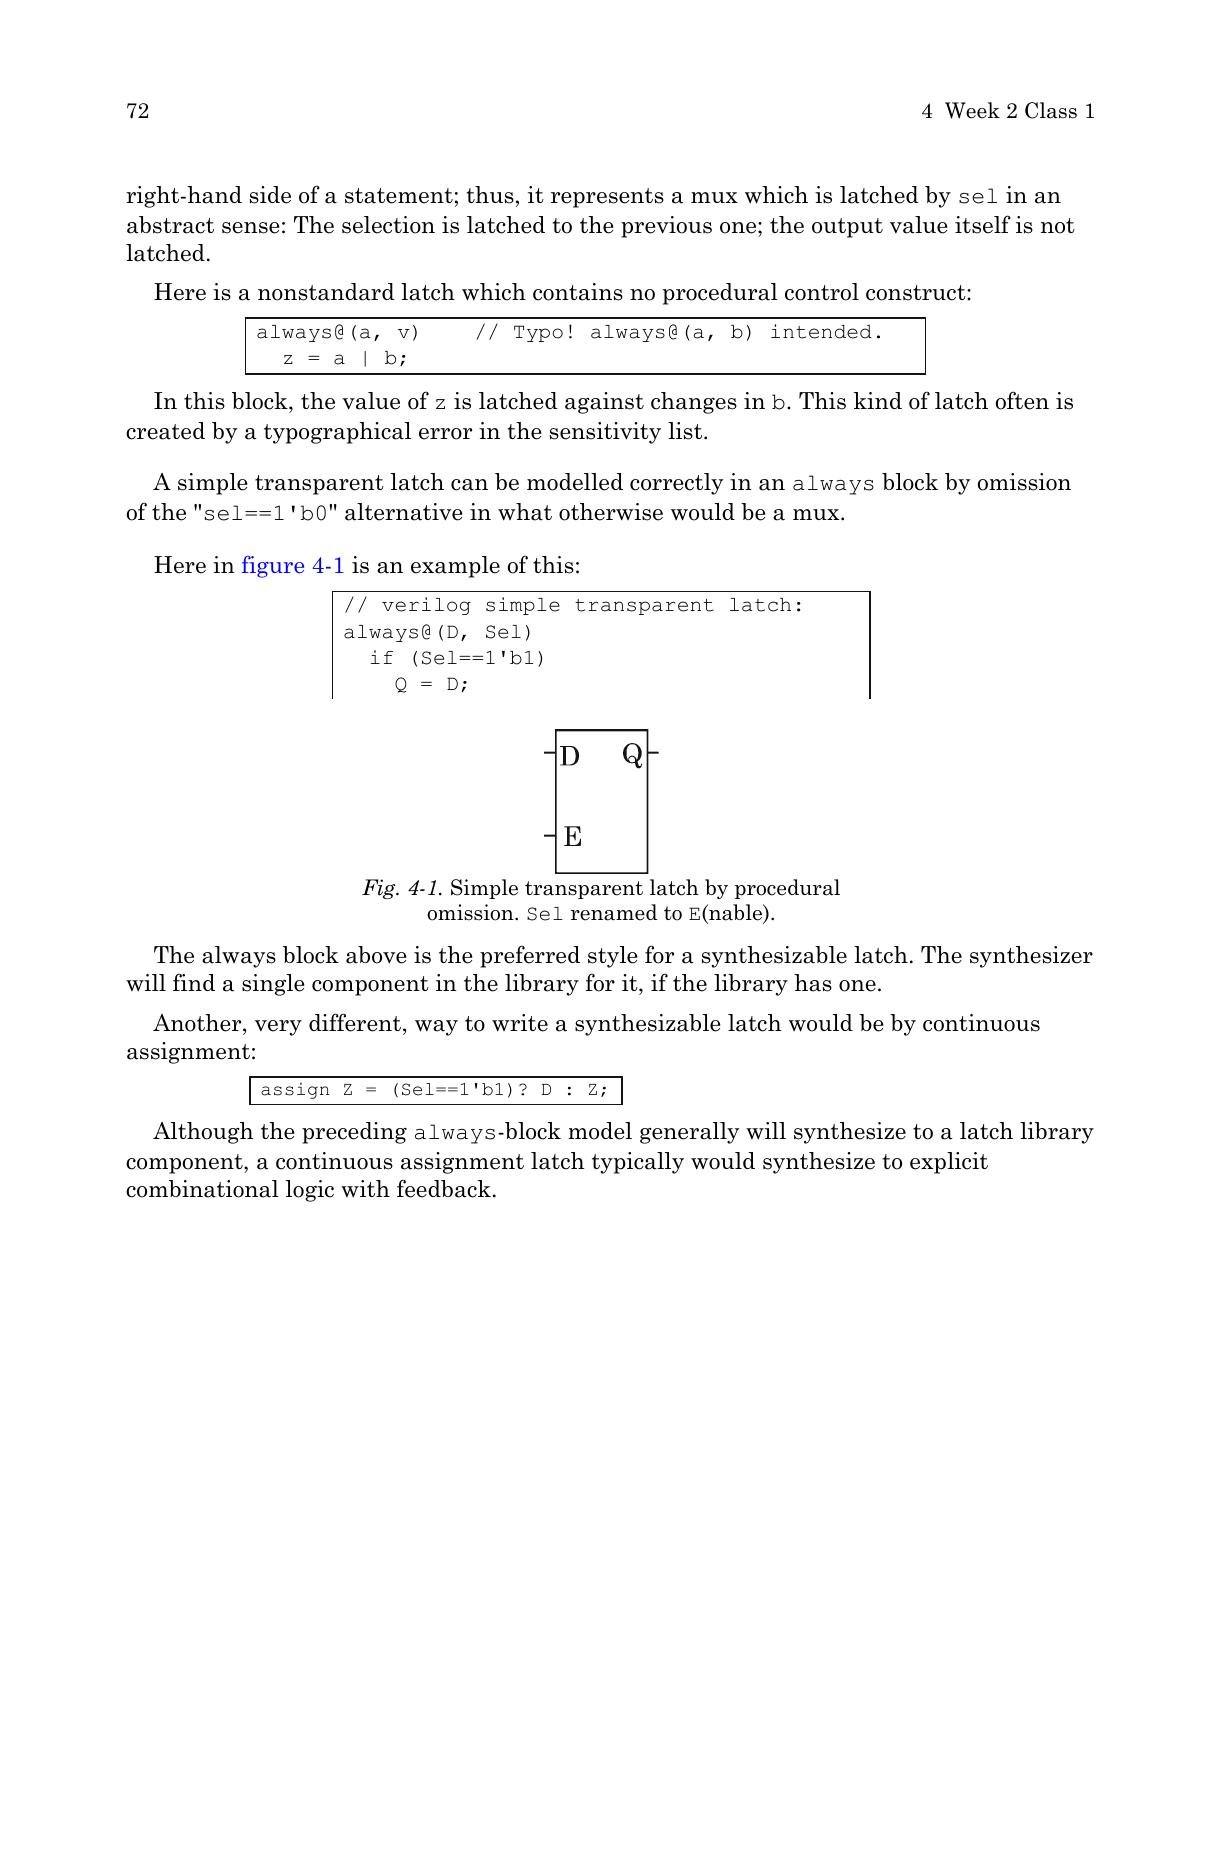

In [162]:
display.Image(tester["image_directory"])

## Supervised Query Function

In [ ]:
# oneshot code
image_to_code = "Please respond with only the code present in this image."
image_to_question = "Please respond with a question for which the answer is the code snippet on this page."
image_to_figure = "Respond with the figure associated with the code present in this image."
code_to_description = "You are a helpful assistant that describes pieces of code."

def info_from_image(image_path, atmps=3, verbose=False, ext='jpeg'):
    """ takes in the link of a local image and gets information about code on it """
    if ext == "jpeg":
        base64_image = encode_image(image_path)
        image_link = f"data:image/{ext};base64,{base64_image}"
    elif ext == "pdf":  # https://stackoverflow.com/questions/3715493/encoding-an-image-file-with-base64
        with open(image_path, "rb") as image_file:
            base64_image = base64.b64encode(image_file.read())
            image_link = f"data:image/{ext};base64,{base64_image}"
    errors = []
    
    attempts = 0
    raw_code = None  # get gpt to extract code
    while attempts < atmps:
        try:
            raw_code = gpt_image_oneshot(image_link, image_to_code)
            attempts = atmps
        except Exception as e:
            attempts += 1
            errors.append(str(e))
    if raw_code == None:
        print("couldnt get code after", atmps, "attempts")
        print(errors[-1])
    processed_code = "" if raw_code == None else '\n'.join(get_code(raw_code))
    
    attempts = 0
    figure = None  # get gpt to ask a question relating to the code
    while attempts < atmps:
        try:
            figure = gpt_image_oneshot(image_link, image_to_figure)
            attempts = atmps
        except Exception as e:
            attempts += 1
            errors.append(str(e))
    if figure == None:
        print("couldnt get figure after", atmps, "attempts")
        print(errors[-1])
    
    attempts = 0
    question = None  # get gpt to ask a question relating to the code
    while attempts < atmps:
        try:
            question = gpt_image_oneshot(image_link, image_to_question)
            attempts = atmps
        except Exception as e:
            attempts += 1
            errors.append(str(e))
    if question == None:
        print("couldnt get question after", atmps, "attempts")
        print(errors[-1])
    
    attempts = 0
    description = None  # get gpt to describe the code
    if raw_code != None:
        desc_prompt = "Write a short description for what this piece of Verilog code does:\n" + processed_code
        while attempts < atmps:
            try:
                description = gpt_oneshot(desc_prompt, code_to_description)
                attempts = atmps
            except Exception as e:
                attempts += 1
                errors.append(str(e))
        if description == None:
            print("couldnt get description after", atmps, "attempts")
            print(errors[-1])
    
    return [image_path, raw_code, processed_code, figure, question, description]

### Small Test Case

tester_im = cwd+"/testpage.jpg"
results = info_from_image(tester_im, 10, True)
display.Image(tester_im)

In [ ]:
print(results[4])
print()
print(results[5])
print()
print(results[3])
print()
print(results[2])

## Running Analysis of all Pages

In [ ]:
# MANUAL SPLITTER: https://pdfcandy.com/blog/how-to-split-pdf-on-mac.html
# MANUAL CONVERTER: https://png2jpg.com/

# find files
book = "LogicDesignAndVerification-Thomas"
# images_dir = "/Data/example-code/verilog examples/Textbook SVA/" + book
images_dir = cwd+"/Data/example-code/verilog examples/pages"
all_images = [images_dir+"/"+file for file in os.listdir(images_dir) if ".jpg" in file]
print("loaded", len(all_images), "jpg images")

# TODO: finalize auto-split & convert
# from pdf2image import convert_from_path
# pages_dir = images_dir+"/pages"
# all_pages = [cwd+pages_dir+"/"+file for file in os.listdir(cwd+pages_dir) if ".pdf" in file]
# page_count = 0
# def pdf_to_jpegs(imdir, verbose=True):
#     """ convert from multi-page pdf to single-page jpeg """
    
#     if verbose: print("...converting", imdir)
#     # https://stackoverflow.com/questions/46184239/extract-a-page-from-a-pdf-as-a-jpeg
#     pages = convert_from_path(imdir)  # TODO: fix
#     for page in pages:
#         newpage_dir = pages_dir + "/" + book + "-p" + str(page_count) + ".jpg"
#         page.save(newpage_dir, 'JPEG')
#         all_pages.append(newpage_dir)
#         page_count += 1
        
# for im in all_images:

In [ ]:
all_results = []
for im in tqdm(all_images):
    results = info_from_image(im, 10, True)
    all_results.append(results)

### Cleaning Results

In [ ]:
df = pd.DataFrame(all_results, columns=["Path", "raw_code", "Code", "Figure", "Question", "Description"])

# recover author
def get_origin(im):
    if "creenshot" in im:
        return "Mehta"
    else:
        return "Thomas" 
df["Book"] = df["Path"].apply(lambda x: get_origin(x))  

# cleaning
df, failed_count, messages, inds = get_failed_request(df)
df.isna().sum()

In [ ]:
df

### Saving Results

In [ ]:
save_dir = "Data/example-code/verilog examples/pages-gptresponse.csv"
df.to_csv(save_dir)
print("SAVED TO", save_dir)

# df = pd.read_csv(save_dir)

In [ ]:
# Future Work Notes

# TODO: use this as a baseline for future examples
# TODO: assertion-specific dataset and 
# TODO: later, then a more general datas
# raw code datasets --> snippers can be wrong and have bugs - llms are fine-tuned on prompts and responses
# creation of the first "high-quality" prompt-response dataset with sva --> 

# RAW PYTHON, RAW SVA, SUPERVISED SVA (from textbooks)
# Note; should be qualitative analysis with examples --> primarily this is the dataset, the crux is that this is one benefit of using the dataset
# conclude with some basic evaluation of the usefulness of the dataset

## Short Analysis

In [ ]:
df = pd.read_csv("Data/example-code/verilog examples/pages-gptresponse.csv")
df.head()

In [ ]:
ind = 3
print(df.iloc[ind]["Code"])

In [ ]:
display.Image(df.iloc[ind]["Path"])